In [1]:
import redshift_connector as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

In [42]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
%matplotlib inline
pd.set_option('mode.chained_assignment',None)
pd.options.display.max_columns = 50
pd.set_option('display.max_columns', 500)

In [4]:
#has dups, 1183 ---> 1100 without dups
df = pd.read_csv('Reassigments  March to Sept 2022 - Sheet1.csv')

In [5]:
df['Reason'].unique()

array(['Gender Preference', 'Provider/Therapist Performance',
       'State Change', 'Provider/Therapist Termed', 'Reactivation',
       'General Fit', 'Scheduling Conflict', 'Racial Preference',
       'LGBTQ+', 'scheduling Conflict', 'timekit', 'General fit',
       'State change', 'State Chage', 'Insurance', 'Timekit Issue',
       'Vacation ', 'Reactivation ', 'Medication added',
       'Cancelled due to access issue', 'State CHange', 'Added Therapy ',
       'LGBTQ', 'General Fit ', 'General fit ', nan,
       'Racial/Gender Prefernce ', 'general fit', 'Gender Prefernce',
       'General Preference ', 'Insurance Issue', 'State Change ',
       'General preference ', 'Added Medication', 'reactivation',
       'Gender', 'Added Therapy', 'added RX',
       'Provider / Therapist Termed', 'Ethnicity Preference',
       'Added Mediaction', 'Added RX', 'New Sign up', 'added Therapy ',
       'added Therapy', 'Added Therapsy ', 'Provider Sick',
       'Other (see notes)', 'Scheduling Issu

In [6]:
df['Reason'] = df['Reason'].str.lower().str.strip()

In [7]:
#cleaning reasons
df['Reason'] = df['Reason'].replace(['general preference','race/ethnicity','ethnicity preference','gender preference','racial/gender prefernce','gender','gender prefernce','racial preference'],'racial/gender preferences')
df['Reason'] = df['Reason'].replace(['provider / therapist termed','insurance issue','added therapsy','added medication','timekit','lgbtq+','state chage'],['provider/therapist termed','insurance','added therapy','added rx','timekit issue','lgbtq','state change'])
df['Reason'] = df['Reason'].replace(['added therapy','medication added','added mediaction','added rx'],'added medication/therapy')
df['Reason'] = df['Reason'].replace(['new sign up',"reactivation (back to same provider)"],'reactivation')
df['Reason'] = df['Reason'].replace(['vacation','provider sick','scheduling issue','scheduling issue','cancelled due to access issue','scheduling conflict'],'scheduling issues')
df['Date'] = df['Date'].replace(['6/17/2021','9/27/2021','8/3/1022'],['6/17/2022','9/27/2022','8/3/2022'])

In [8]:
df.rename(columns={'Date':'date','Case ID':'case_id','Reason': 'reason','Provider or Therapist?':'practitioner_type'}, inplace = True)

In [9]:
df['reason'].unique()

array(['racial/gender preferences', 'provider/therapist performance',
       'state change', 'provider/therapist termed', 'reactivation',
       'general fit', 'scheduling issues', 'lgbtq', 'timekit issue',
       'insurance', 'added medication/therapy', nan, 'other (see notes)',
       'performance issue'], dtype=object)

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
#needed to import to database to join tables. analytics doesnt have an instance yet so tables take hours to load in local host
#df.to_csv('reassignments_cleansed.csv', index = False)

In [12]:
df = pd.read_csv('reassignments_cleansed.csv')

In [13]:
df['before_reassignment_total_bookings_showed_medication'].fillna(0, inplace=True)
df['before_reassignment_total_bookings_showed_therapy'].fillna(0, inplace=True)

In [14]:
df['practitioner_type'].unique()

array(['Provider', 'Therapist', 'Both', nan, 'Provider / Therapist',
       'Provider / therapist', 'Provider/Therapist',
       'Both (Provider and Therapist)', 'Therapsit'], dtype=object)

In [15]:
df['practitioner_type'] = df['practitioner_type'].replace(['Therapsit'],'Therapist')
df['practitioner_type'] = df['practitioner_type'].replace(['Provider / Therapist','Provider/Therapist',"Both (Provider and Therapist)","Provider / therapist"],'Both')
df.loc[(df['practitioner_type']== 'Both') & (df['first_medication_booking_showed_date'].notnull()) & (df['first_therapy_booking_showed_date'].isnull()),'practitioner_type'] = 'Provider'
df.loc[(df['practitioner_type'].isnull()) & (df['first_medication_booking_showed_date'].notnull()) & (df['first_therapy_booking_showed_date'].isnull()),'practitioner_type'] = 'Provider'
df.loc[(df['practitioner_type']== 'Both') & (df['first_medication_booking_showed_date'].isnull()) & (df['first_therapy_booking_showed_date'].notnull()),'practitioner_type'] = 'Therapist'
df.loc[(df['practitioner_type'].isnull()) & (df['first_medication_booking_showed_date'].isnull()) & (df['first_therapy_booking_showed_date'].notnull()),'practitioner_type'] = 'Therapist'
df.loc[(df['practitioner_type']=='Both') &(df['first_therapy_booking_showed_date'].isnull()) & (df['first_medication_booking_showed_date'].isnull()) & (df['last_provider_id_assigned'].isnull()) & (df['last_therapist_id_assigned'].notnull()),'practitioner_type'] = 'Therapist'
df.loc[(df['practitioner_type']=='Both') &(df['first_therapy_booking_showed_date'].isnull()) & (df['first_medication_booking_showed_date'].isnull()) & (df['last_provider_id_assigned'].notnull()) & (df['last_therapist_id_assigned'].isnull()),'practitioner_type'] = 'Provider'
df.loc[(df['practitioner_type'].isnull()) &(df['first_therapy_booking_showed_date'].isnull()) & (df['first_medication_booking_showed_date'].isnull()) & (df['last_provider_id_assigned'].isnull()) & (df['last_therapist_id_assigned'].notnull()),'practitioner_type'] = 'Therapist'
df.loc[(df['practitioner_type'].isnull()) &(df['first_therapy_booking_showed_date'].isnull()) & (df['first_medication_booking_showed_date'].isnull()) & (df['last_provider_id_assigned'].notnull()) & (df['last_therapist_id_assigned'].isnull()),'practitioner_type'] = 'Provider'

In [16]:
df['value'] = 1 
df.loc[df['practitioner_type'].isnull(),'practitioner_type'] = 'Unknown'
df['practitioner_type'].unique()

array(['Provider', 'Therapist', 'Both', 'Unknown'], dtype=object)

In [17]:
df['subscriber_last_plan_type'].fillna('Unknown', inplace = True)
df['reason'].fillna('Unknown', inplace = True)
reasons_summary = pd.pivot_table(data=df,index='reason',aggfunc='count',columns = (['practitioner_type']), values = 'value', margins=True)
reasons_summary.fillna(0, inplace = True)
reasons_summary

practitioner_type,Both,Provider,Therapist,Unknown,All
reason,,,,,
Unknown,0.0,1.0,0.0,0.0,1
added medication/therapy,0.0,8.0,35.0,0.0,43
general fit,1.0,103.0,153.0,24.0,281
insurance,1.0,4.0,1.0,0.0,6
lgbtq,0.0,0.0,3.0,1.0,4
other (see notes),1.0,9.0,17.0,0.0,27
performance issue,0.0,5.0,2.0,0.0,7
provider/therapist performance,1.0,65.0,42.0,9.0,117
provider/therapist termed,0.0,17.0,19.0,2.0,38


In [18]:
sum(df['practitioner_type'].isnull())

0

In [19]:
sum(df['practitioner_type']=='Both')

42

In [20]:
df['reassignment_date'] = pd.to_datetime(df['reassignment_date'])
df['first_booking_showed_date_all'] = pd.to_datetime(df['first_booking_showed_date_all'])
df['last_canceled_plan_timestamp'] = pd.to_datetime(df['last_canceled_plan_timestamp'])
df['most_recent_booking_after_reassignment_date'] = pd.to_datetime(df['most_recent_booking_after_reassignment_date'])

In [21]:
df['days_since_reassignment_to_plan_cancellation'] = df['last_canceled_plan_timestamp'] - df['reassignment_date']
df['days_since_reassignment_to_plan_cancellation'] = df['days_since_reassignment_to_plan_cancellation'].dt.days
df['days_since_reassignment_to_booking_start'] = df['most_recent_booking_after_reassignment_date'] - df['reassignment_date']
df['days_since_reassignment_to_booking_start'] = df['days_since_reassignment_to_booking_start'].dt.days

In [22]:
df['cancellation_after_reassignment_flag'] = df['reassignment_date'] <= df['last_canceled_plan_timestamp']

In [23]:
df['cancellation_after_reassignment_flag'].value_counts()

False    827
True     283
Name: cancellation_after_reassignment_flag, dtype: int64

In [24]:
#booking cancellations on or after reassignment date but before most recent booking date after reassigntment date
#if most_recent_booking_after_reassignment_date is null then and booking_cancallation received on or after reassignment date then a visit was cancelled 
df.loc[df['booking_status_cancellation_considered'].notnull(),'has_booking_after_reassignment'] = True
df.loc[df['booking_status_cancellation_considered'].isnull(),'has_booking_after_reassignment'] = False

In [25]:
df['has_booking_after_reassignment'].value_counts()

True     1007
False     103
Name: has_booking_after_reassignment, dtype: int64

In [26]:
#filtered booking start before 9/25 because > 9/25 has not matured yet aka outcomes still not loaded to database
bookings = df.loc[(df['has_booking_after_reassignment']== True) & (df['most_recent_booking_after_reassignment_date'] < '2022-09-25')]
bookings['booking_status_cancellation_considered'].value_counts()

resolved       582
confirmed      123
cancelled      104
no-showed       94
rescheduled     18
showed           4
Name: booking_status_cancellation_considered, dtype: int64

In [27]:
bookings.loc[bookings['booking_status_cancellation_considered'].isin(['resolved','showed']),'booking_status_cancellation_considered'] = 'resolved/showed'
bookings.loc[bookings['booking_status_cancellation_considered'].isin(['cancelled','confirmed','rescheduled','no-showed']),'booking_status_cancellation_considered'] = 'cancelled/confirmed/rescheduled/no-showed'

In [28]:
bookings['booking_status_cancellation_considered'].value_counts()

resolved/showed                              586
cancelled/confirmed/rescheduled/no-showed    339
Name: booking_status_cancellation_considered, dtype: int64

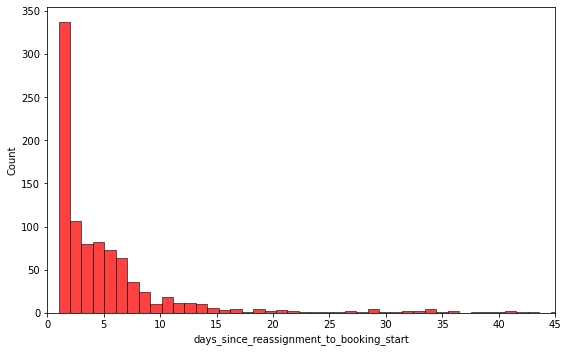

In [29]:
#majority of members still book within 15 days after being reassigned
plt.figure(figsize=(8,5))
bs_fig = sns.histplot(x='days_since_reassignment_to_booking_start',data=bookings,color = 'red')
bs_fig.set_xlim(0,45)
plt.tight_layout()

In [30]:
bookings.loc[bookings['booking_status_cancellation_considered'] == 'cancelled/confirmed/rescheduled/no-showed','cancelled/confirmed/rescheduled/no-showed'] = 1 
bookings.loc[bookings['booking_status_cancellation_considered'] != 'cancelled/confirmed/rescheduled/no-showed','cancelled/confirmed/rescheduled/no-showed'] = 0 
bookings.loc[bookings['booking_status_cancellation_considered'] == 'resolved/showed','resolved/showed']= 1
bookings.loc[bookings['booking_status_cancellation_considered'] != 'resolved/showed','resolved/showed']= 0
bookings.loc[bookings['practitioner_type'].isnull(),'practitioner_type'] = 'Unknown'

In [31]:
bookings_outcomes = pd.pivot_table(bookings,index = ['practitioner_type'],aggfunc = 'sum',values = ['cancelled/confirmed/rescheduled/no-showed','resolved/showed'], margins = True)

In [32]:
bookings_outcomes['total_visits'] = bookings_outcomes['cancelled/confirmed/rescheduled/no-showed'] + bookings_outcomes['resolved/showed']
bookings_outcomes['completion_pct'] = bookings_outcomes['resolved/showed'] / bookings_outcomes['total_visits']
bookings_outcomes['incompletion_pct'] = bookings_outcomes['cancelled/confirmed/rescheduled/no-showed'] / bookings_outcomes['total_visits']
bookings_outcomes

,cancelled/confirmed/rescheduled/no-showed,resolved/showed,total_visits,completion_pct,incompletion_pct
practitioner_type,,,,,
Both,17.0,20.0,37.0,0.540541,0.459459
Provider,139.0,268.0,407.0,0.658477,0.341523
Therapist,154.0,256.0,410.0,0.624390,0.375610
Unknown,29.0,42.0,71.0,0.591549,0.408451
All,339.0,586.0,925.0,0.633514,0.366486


In [33]:
reasons = pd.pivot_table(bookings,index = ['reason'],aggfunc = 'sum',values = ['cancelled/confirmed/rescheduled/no-showed','resolved/showed'], margins = True)
reasons['total_visits'] = reasons['cancelled/confirmed/rescheduled/no-showed'] + reasons['resolved/showed']
reasons['completion_pct'] = reasons['resolved/showed'] / reasons['total_visits']
reasons['incompletion_pct'] = reasons['cancelled/confirmed/rescheduled/no-showed'] / reasons['total_visits']
reasons

,cancelled/confirmed/rescheduled/no-showed,resolved/showed,total_visits,completion_pct,incompletion_pct
reason,,,,,
Unknown,0.0,1.0,1.0,1.000000,0.000000
added medication/therapy,14.0,25.0,39.0,0.641026,0.358974
general fit,79.0,146.0,225.0,0.648889,0.351111
insurance,0.0,6.0,6.0,1.000000,0.000000
lgbtq,2.0,2.0,4.0,0.500000,0.500000
other (see notes),1.0,3.0,4.0,0.750000,0.250000
performance issue,1.0,2.0,3.0,0.666667,0.333333
provider/therapist performance,34.0,69.0,103.0,0.669903,0.330097
provider/therapist termed,19.0,18.0,37.0,0.486486,0.513514


In [34]:
#removing all the bookings from this analysis, in the same period of time 3/4/2022 to 9/25/2022 
#for 91367 follow-ups, the completion pct is 78.7% and the incompletion pct is 21%
#in comparison the completion pct declined almost 20 pts, and incompletion pct increased 20 pts

In [35]:
def bins(x):
    if x > 10:
        return 'd. 10+'
    if x >5 <= 10:
        return 'c. 6 to 10'
    if x > 0 <= 5:
        return 'b. 1 to 5'
    if x == 0:
        return 'a. 0'

In [36]:
#bins of medication visit prior to reassignment date for cancellations marked as 'Provider' related
df['medication_visits_totals'] = df['before_reassignment_total_bookings_showed_medication'].apply(lambda x: bins(x))
#bins of therapy visit prior to reassignment date for cancellations marked as 'Therapy' related
df['therapy_visits_totals'] = df['before_reassignment_total_bookings_showed_therapy'].apply(lambda x: bins(x))
df['total_vists'] = df['before_reassignment_total_bookings_showed_therapy'] + df['before_reassignment_total_bookings_showed_medication']
#bins of total visit prior to reassignment date for cancellations marked as 'Both' or 'Unknown' related
df['total_vists'] = df['total_vists'].apply(lambda x: bins(x))

In [37]:
provider_related = df.loc[df['practitioner_type'] == 'Provider']
therapist_related = df.loc[df['practitioner_type'] == 'Therapist']
both_or_unknown_related = df.loc[df['practitioner_type'].isin(['Unknown','Both'])]

In [38]:
df['medication_visits_totals'].value_counts()

b. 1 to 5     792
a. 0          262
c. 6 to 10     51
d. 10+          5
Name: medication_visits_totals, dtype: int64

In [39]:
#reassignments attributed to providers
pd.pivot_table(data=provider_related,index='reason',aggfunc='count',values = 'value',columns = 'medication_visits_totals', margins = True).fillna(0)

medication_visits_totals,a. 0,b. 1 to 5,c. 6 to 10,d. 10+,All
reason,,,,,
Unknown,0.0,1.0,0.0,0.0,1
added medication/therapy,7.0,1.0,0.0,0.0,8
general fit,23.0,71.0,8.0,1.0,103
insurance,0.0,3.0,1.0,0.0,4
other (see notes),4.0,5.0,0.0,0.0,9
performance issue,2.0,3.0,0.0,0.0,5
provider/therapist performance,27.0,35.0,3.0,0.0,65
provider/therapist termed,0.0,16.0,0.0,1.0,17
racial/gender preferences,18.0,18.0,2.0,0.0,38


In [40]:
#reassignments attributed to therapists
pd.pivot_table(data=therapist_related,index='reason',aggfunc='count',values = 'value',columns = 'therapy_visits_totals', margins = True).fillna(0)

therapy_visits_totals,a. 0,b. 1 to 5,c. 6 to 10,d. 10+,All
reason,,,,,
added medication/therapy,26.0,7.0,2.0,0.0,35
general fit,37.0,96.0,13.0,7.0,153
insurance,0.0,1.0,0.0,0.0,1
lgbtq,2.0,1.0,0.0,0.0,3
other (see notes),12.0,4.0,1.0,0.0,17
performance issue,0.0,2.0,0.0,0.0,2
provider/therapist performance,26.0,15.0,1.0,0.0,42
provider/therapist termed,3.0,8.0,5.0,3.0,19
racial/gender preferences,41.0,27.0,3.0,2.0,73


In [41]:
#reassignments attributed to both or unknown
pd.pivot_table(data=both_or_unknown_related,index='reason',aggfunc='count',values = 'value',columns = 'total_vists', margins = True).fillna(0)

total_vists,a. 0,b. 1 to 5,c. 6 to 10,d. 10+,All
reason,,,,,
general fit,2.0,12.0,8.0,3.0,25
insurance,0.0,0.0,0.0,1.0,1
lgbtq,1.0,0.0,0.0,0.0,1
other (see notes),0.0,0.0,1.0,0.0,1
provider/therapist performance,4.0,5.0,0.0,1.0,10
provider/therapist termed,0.0,1.0,1.0,0.0,2
racial/gender preferences,5.0,1.0,1.0,1.0,8
reactivation,0.0,10.0,0.0,3.0,13
scheduling issues,2.0,8.0,1.0,3.0,14
